In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

In [3]:
# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V

from utils.topic_comparison import compare_topic_queryset, save_res, sort_matrix, draw_score_matrix
from utils.topic_comparison import save_topic_list_as_table, draw_bipartite_topic_graph, bipartite_graph_from_matrix

/home/finn/anaconda3/envs/textmining/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
#RunStats.objects.filter(psearch__title="Kohle pdf utterance", method='NM', K=50)

In [27]:
run_tm(60, 30, method='lda')

creating term frequency matrix (0.1734614372253418)
save terms to db (8.62721562385559)
running Latent Dirichlet Allocation (56.19216871261597)
saving document topic matrix to db (95.75513291358948)
topic model run done (113.5510413646698)


0

In [28]:
K1 = 30
K2 = 30
method = 'LD'
search_word = "Kohle"
run_id1 = RunStats.objects.get(psearch__title="{} tei utterance".format(search_word), method=method, K=K1).run_id
run_id2 = RunStats.objects.get(psearch__title="{} tei paragraph".format(search_word), method=method, K=K2).run_id

stat1 = RunStats.objects.get(pk=run_id1)
topics1 = Topic.objects.filter(run_id=stat1.parent_run_id).order_by('-score')

stat2 = RunStats.objects.get(pk=run_id2)
topics2 = Topic.objects.filter(run_id=stat2.parent_run_id).order_by('-score')

print(run_id1)
print(run_id2)

47
128


In [29]:
save_topic_list_as_table(topics1, "topic_list_{}_{}_K{}_tei.csv".format(search_word, method, K1))

0

['run_47_topics_30', 'scores_47', 'similarity_47-128', 'run_128_topics_30', 'scores_128']
C2:C30
matching sum:	83.0
max rows:	100.0
max cols:	89.0


0

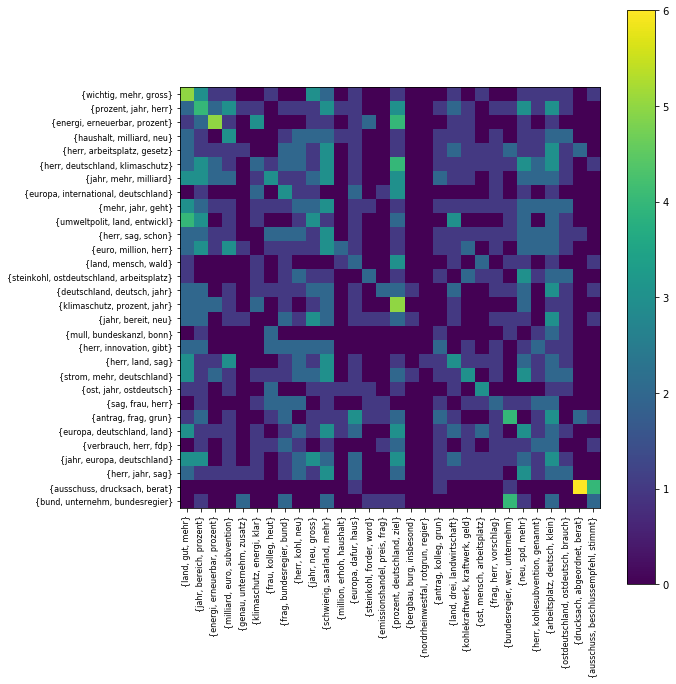

In [30]:
# Compares NMF and LDA methods for K=30
% matplotlib inline

runs = [run_id1, run_id2]
#runs = [969,973]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "."}
save_res(runs, [res_tw,ss], options)

#draw_score_matrix(score_matrix, topics1, topics2, match=True, filename="topword_score_matrix_{}_{}_K{}.pdf".format(search_word, method, K))
draw_score_matrix(score_matrix, topics1, topics2, match=True, filename="topword_score_matrix_{}_{}_K1{}_K2{}.png".format(search_word, method, K1, K2))

['run_47_topics_30', 'scores_47', 'similarity_47-128', 'run_128_topics_30', 'scores_128']
C2:C30
matching sum:	83.0
max rows:	100.0
max cols:	89.0


0

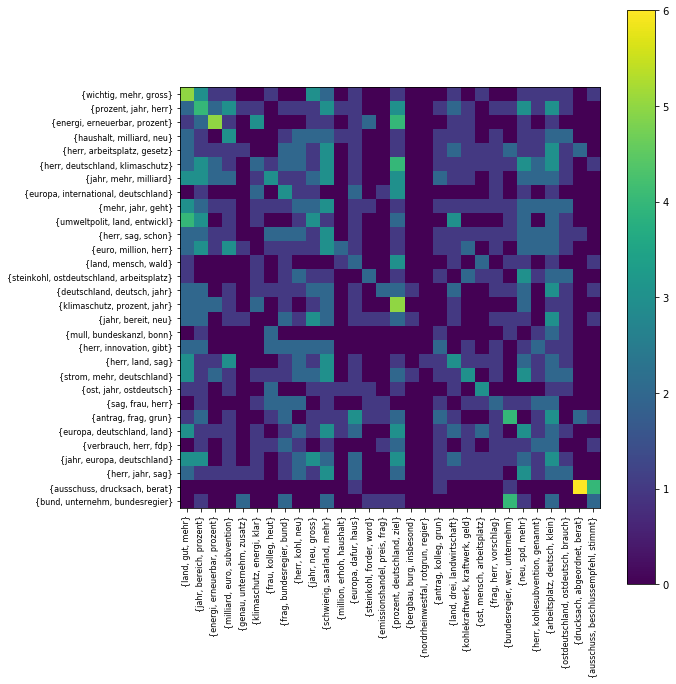

In [31]:
#Top Word Overlap comparison method
% matplotlib inline

runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "."}
save_res(runs, [res_tw,ss], options)

#draw_score_matrix(score_matrix[0], topics1, topics2, match=True, filename="topword_score_matrix_{}_{}_K{}.pdf".format(search_word, method, K))
draw_score_matrix(score_matrix, topics1, topics2, match=True, filename="topword_score_matrix_{}_{}_K{}_{}.png".format(search_word, method, K1, K2))

['run_47_topics_30', 'scores_47', 'similarity_47-128', 'run_128_topics_30', 'scores_128']
matching sum:	1704226477121.5005
max rows:	2596250635088.2764
max cols:	2706703822745.757


0

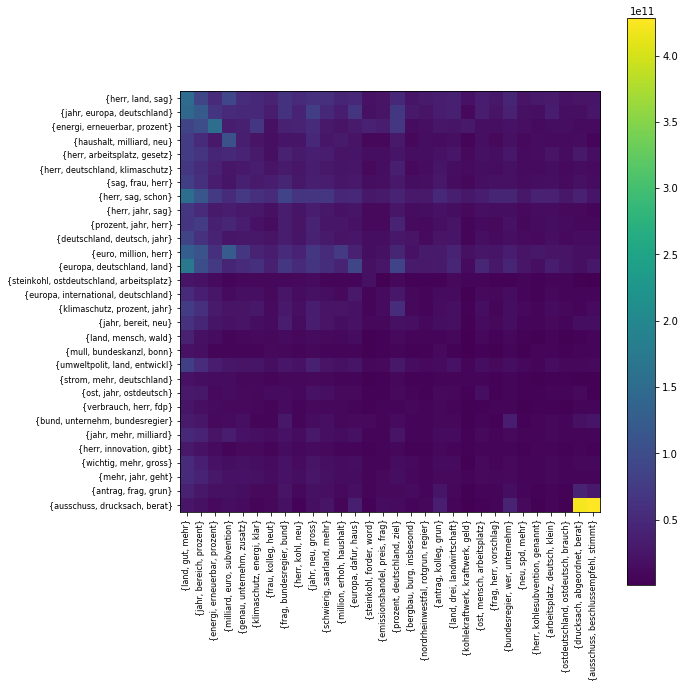

In [32]:
#Score Product comparison method
res, ss, score_prod_matrix = compare_topic_queryset(runs, method="score_product", order_by_str='-score')

#draw_score_matrix(score_prod_matrix, topics1, topics2, match=True, filename="prod_score_matrix_{}_{}_K{}.pdf".format(search_word, method, K))
draw_score_matrix(score_prod_matrix, topics1, topics2, match=True, filename="prod_score_matrix_{}_{}_K1{}_K2{}.png".format(search_word, method, K1, K2))

In [33]:
matrix1, permutation1 = sort_matrix(score_matrix)
matrix2, permutation2 = sort_matrix(score_prod_matrix)

sum(permutation1 == permutation2)

matching sum:	83.0
max rows:	100.0
max cols:	89.0
matching sum:	1704226477121.5005
max rows:	2596250635088.2764
max cols:	2706703822745.757


10

In [34]:
from termcolor import colored

def print_topics(topics1, topics2):
    
    for i in range(len(topics1)):
        sim_score = len(set(topics1[i].top_words).intersection(set(topics2[i].top_words)))

        if topics1[i].top_words == topics2[i].top_words:
            print("#{}: score: {}, matching".format(i, sim_score))
        elif sim_score > 5:
            print("#{}: score: {}, not matching".format(i, sim_score))
        else:
            print(colored("#{}: score: {}, not matching".format(i, sim_score), 'red'))

        print("{}\n{}".format(", ".join(topics1[i].top_words), ", ".join(topics2[i].top_words)))

matrix1, permutation1 = sort_matrix(score_matrix)
topic_list1 = [topics1[int(permutation1[i])] for i in range(len(topics1))]
        
print_topics(topic_list1, topics2)

matching sum:	83.0
max rows:	100.0
max cols:	89.0
#0: score: 5, not matching
wichtig, mehr, gross, produkt, ganz, deshalb, beispiel, erst, schon, jahr
land, gut, mehr, neu, gross, jahr, problem, natur, erst, beispiel
#1: score: 4, not matching
prozent, jahr, herr, hoh, mehr, million, deutsch, euro, milliard, deutschland
jahr, bereich, prozent, schon, tonn, rund, million, deutsch, anteil, wichtig
#2: score: 5, not matching
energi, erneuerbar, prozent, kernenergi, deutschland, strom, jahr, energiepolit, kraftwerk, ziel
energi, erneuerbar, prozent, strom, mehr, nutzung, energietrag, kernkraftwerk, kohl, kernenergi
#3: score: 3, not matching
haushalt, milliard, neu, jahr, investition, okosteu, herr, steuerreform, subvention, ausgab
milliard, euro, subvention, jahr, forschung, fdp, kost, anlag, pro, red
#4: score: 1, not matching
herr, arbeitsplatz, gesetz, unternehm, jahr, steu, wettbewerb, mehr, gesetzentwurf, hoh
genau, unternehm, zusatz, forder, punkt, mocht, million, versuch, massnahm,

In [35]:
matrix = score_matrix
if sum([row.max() for row in matrix]) > sum([col.max() for col in matrix.T]):
    permutation = [row.argmax() for row in matrix]
else:
    permutation = [col.argmax() for col in matrix.T]

topic_list2 = [topics2[int(permutation[i])] for i in range(K2)]

print_topics(topics1, topic_list2)

#0: score: 5, not matching
energi, erneuerbar, prozent, kernenergi, deutschland, strom, jahr, energiepolit, kraftwerk, ziel
energi, erneuerbar, prozent, strom, mehr, nutzung, energietrag, kernkraftwerk, kohl, kernenergi
#1: score: 3, not matching
herr, sag, schon, heut, ganz, gibt, mehr, gesagt, gesetz, jahr
schwierig, saarland, mehr, regel, sozial, jahr, herr, wirtschaft, endlich, betroff
#2: score: 4, not matching
herr, deutschland, klimaschutz, sag, mehr, prozent, schon, bundesregier, jahr, ganz
prozent, deutschland, ziel, erreich, gegenub, jahr, europa, bundesregier, beitrag, klimaschutzziel
#3: score: 3, not matching
euro, million, herr, haushalt, mehr, jahr, geld, milliard, mittel, schon
jahr, bereich, prozent, schon, tonn, rund, million, deutsch, anteil, wichtig
#4: score: 2, not matching
sag, frau, herr, frag, gesagt, ganz, geht, word, thema, schon
frau, kolleg, heut, damal, herrn, schon, strukturwandel, prasidentin, kohl, bergleut
#5: score: 3, not matching
deutschland, deutsc

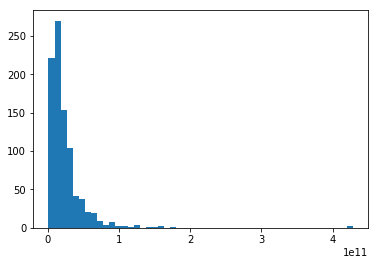

In [36]:
fig = plt.hist(score_prod_matrix.flatten(), bins=50)

matching sum:	83.0
max rows:	100.0
max cols:	89.0


0

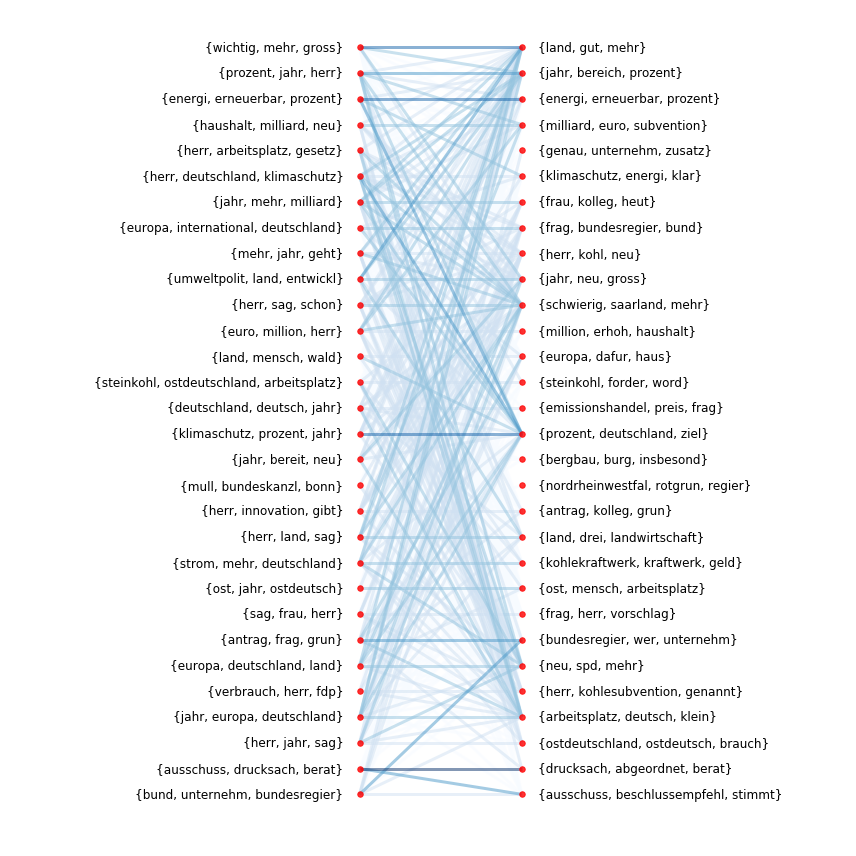

In [37]:
matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K1)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='bipartite_topic_graph_{}_{}_K1{}_K2{}_topword_score'.format(search_word, method, K1, K2))

matching sum:	1704226477121.5005
max rows:	2596250635088.2764
max cols:	2706703822745.757


0

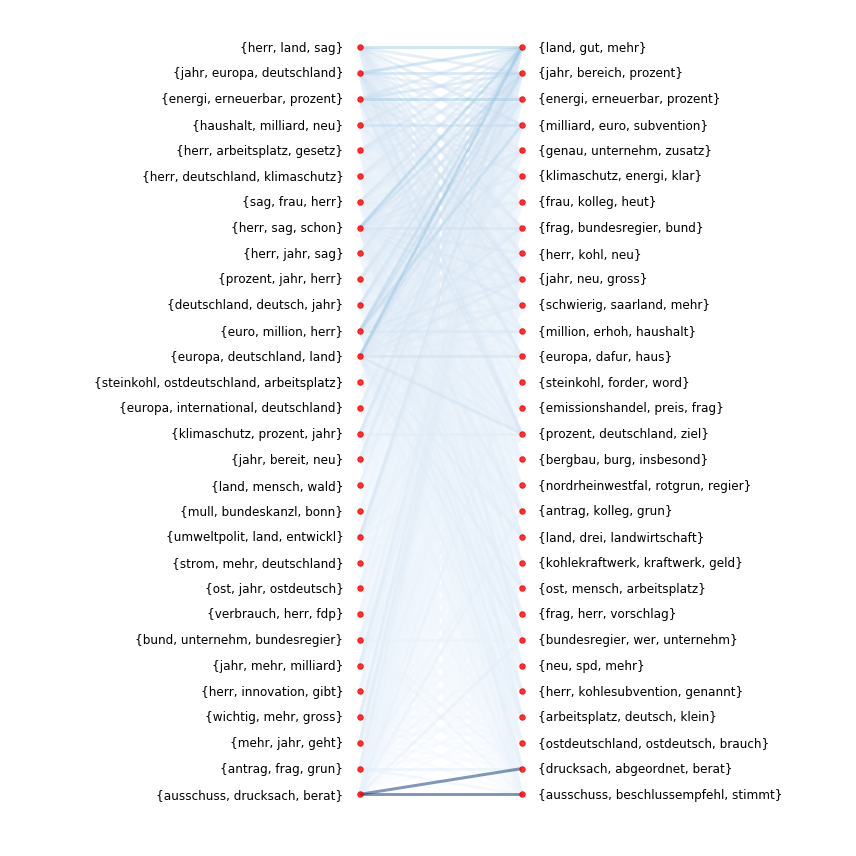

In [38]:
matrix1, permutation1 = sort_matrix(score_prod_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix1, threshold=0.5)
perm_topic_list = [topics1[int(permutation1[i])].title for i in range(K1)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename="bipartite_topic_graph_{}_{}_K1{}_K2{}_prod_score".format(search_word, method, K1, K2))

In [44]:
s = pm.Search.objects.get(id=60)
print(s.search_object_type)
print(s.par_count)

1
4961
